In [1]:
# use conda env "pix2pix"
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import bee_utils as bee

In [2]:
ACTIVATIONS_FILE = Path("../Pointnet_Pointnet2_pytorch/log/classification/2024-07-03_23-11/logs/activations_per_class_2024-07-07_21-31.csv")


In [3]:
df = pd.read_csv(ACTIVATIONS_FILE, sep=",", header="infer")
display(df.head())
print(df.shape)

,sample_path,target_name,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,...,act_246,act_247,act_248,act_249,act_250,act_251,act_252,act_253,act_254,act_255
0,bee\bee_m3_9_173.csv,bee,0.3010,2.0272,4.1678,3.3139,-3.1765,-3.7755,-0.8893,-1.0369,...,1.7473,2.8463,2.6158,0.1144,0.5105,-0.9958,0.2716,-0.4925,3.2274,3.7249
1,dragonfly\dragonfly_h3_16_5.csv,dragonfly,-0.4388,-2.1274,-1.9290,1.6530,2.1485,0.3740,1.4394,1.4486,...,2.7210,-1.9469,0.3603,0.8599,-1.1127,-1.3361,-0.2451,4.1941,-3.2254,-1.3841
2,dragonfly\dragonfly_h3_7_3.csv,dragonfly,-1.6570,-3.2599,-3.4520,-0.1127,3.6516,2.0707,2.0069,0.2193,...,1.2225,-2.7819,-1.7092,-2.6011,-0.5383,0.6987,0.3600,1.3153,-4.2728,-3.1347
3,dragonfly\dragonfly_h3_20_4.csv,dragonfly,-1.8893,-2.6136,-3.1396,-0.1442,3.1646,1.7044,1.5216,0.0714,...,0.6659,-2.3111,-1.7217,-2.6481,-0.7520,0.9051,0.7258,0.6922,-3.6374,-3.0055
4,dragonfly\dragonfly_h3_15_6.csv,dragonfly,-0.9444,-2.8684,-2.3194,0.6992,2.6901,0.9253,2.1163,0.7845,...,1.7728,-2.3983,-0.2892,-0.4470,-0.4031,-0.0552,-0.0644,2.7268,-3.8311,-1.7947


(132, 258)


In [4]:
df['sample_path'].apply(bee.frag_filename_to_id)

0       (m3, 9, 173)
1        (h3, 16, 5)
2         (h3, 7, 3)
3        (h3, 20, 4)
4        (h3, 15, 6)
           ...      
127     (m3, 0, 183)
128      (m3, 9, 37)
129    (m3, 55, 247)
130     (m3, 9, 178)
131      (h7, 26, 2)
Name: sample_path, Length: 132, dtype: object

In [5]:
# Factorize
classes_map = dict(zip(bee.CLASSES, range(len(bee.CLASSES))))
print(classes_map)
df['target_index'] = df['target_name'].map(classes_map)
df["target_index"]

{'bee': 0, 'butterfly': 1, 'dragonfly': 2, 'wasp': 3, 'insect': 4, 'other': 5}


0      0
1      2
2      2
3      2
4      2
      ..
127    0
128    0
129    0
130    0
131    1
Name: target_index, Length: 132, dtype: int64

In [6]:
activations_df = df.loc[:,"act_0":"act_255"]
display(activations_df.head())

,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,...,act_246,act_247,act_248,act_249,act_250,act_251,act_252,act_253,act_254,act_255
0,0.3010,2.0272,4.1678,3.3139,-3.1765,-3.7755,-0.8893,-1.0369,-0.9056,3.7203,...,1.7473,2.8463,2.6158,0.1144,0.5105,-0.9958,0.2716,-0.4925,3.2274,3.7249
1,-0.4388,-2.1274,-1.9290,1.6530,2.1485,0.3740,1.4394,1.4486,3.3848,-0.0106,...,2.7210,-1.9469,0.3603,0.8599,-1.1127,-1.3361,-0.2451,4.1941,-3.2254,-1.3841
2,-1.6570,-3.2599,-3.4520,-0.1127,3.6516,2.0707,2.0069,0.2193,2.3549,-1.0713,...,1.2225,-2.7819,-1.7092,-2.6011,-0.5383,0.6987,0.3600,1.3153,-4.2728,-3.1347
3,-1.8893,-2.6136,-3.1396,-0.1442,3.1646,1.7044,1.5216,0.0714,1.7733,-1.1440,...,0.6659,-2.3111,-1.7217,-2.6481,-0.7520,0.9051,0.7258,0.6922,-3.6374,-3.0055
4,-0.9444,-2.8684,-2.3194,0.6992,2.6901,0.9253,2.1163,0.7845,2.7158,-0.3164,...,1.7728,-2.3983,-0.2892,-0.4470,-0.4031,-0.0552,-0.0644,2.7268,-3.8311,-1.7947


In [7]:
cmap = matplotlib.cm.get_cmap('Set1')
for i in range(8):
    rgba = cmap(i/8)
    print(rgba)


(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0)
(0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0)
(0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(1.0, 1.0, 0.2, 1.0)
(0.6509803921568628, 0.33725490196078434, 0.1568627450980392, 1.0)
(0.9686274509803922, 0.5058823529411764, 0.7490196078431373, 1.0)


In [8]:
colors = bee.get_rgba_of_class_index(df["target_index"])
colors

0                    (1.0, 0.4980392156862745, 0.0, 1.0)
1      (0.21568627450980393, 0.49411764705882355, 0.7...
2      (0.21568627450980393, 0.49411764705882355, 0.7...
3      (0.21568627450980393, 0.49411764705882355, 0.7...
4      (0.21568627450980393, 0.49411764705882355, 0.7...
                             ...                        
127                  (1.0, 0.4980392156862745, 0.0, 1.0)
128                  (1.0, 0.4980392156862745, 0.0, 1.0)
129                  (1.0, 0.4980392156862745, 0.0, 1.0)
130                  (1.0, 0.4980392156862745, 0.0, 1.0)
131    (0.30196078431372547, 0.6862745098039216, 0.29...
Name: target_index, Length: 132, dtype: object

i:\WorkspaceSSD\.conda\envs\pix2pix\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(132, 2)

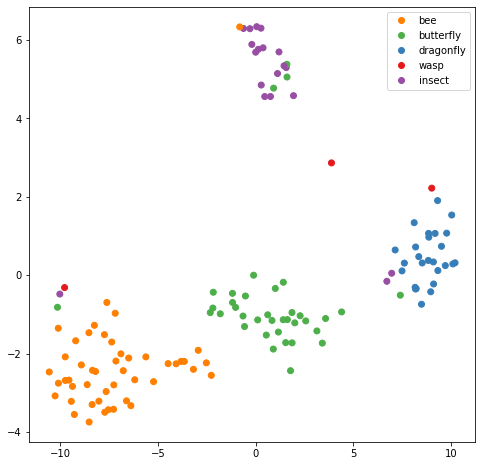

In [12]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, init="pca", learning_rate="auto")
tsne_result = tsne.fit_transform(activations_df)
display(tsne_result.shape)
# (1000, 2)
# Two dimensions for each of our images

colors = bee.get_rgba_of_class_index(df["target_index"])

# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
fig, ax = plt.subplots(1)
# vmin vmax for Colormap normalization; Set1 has 8 colors
scatter = ax.scatter(x=tsne_result[:,0], y=tsne_result[:,1], c=df["target_index"], cmap=bee.CLASS_CMAP, vmin=0, vmax=8)
fig.set_size_inches(8,8)
ax.legend(handles=scatter.legend_elements()[0], labels=bee.CLASSES)

# lim = (tsne_result.min()-5, tsne_result.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

-0.187 0.126


C:\Users\Marc\AppData\Local\Temp\ipykernel_896\3202110962.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


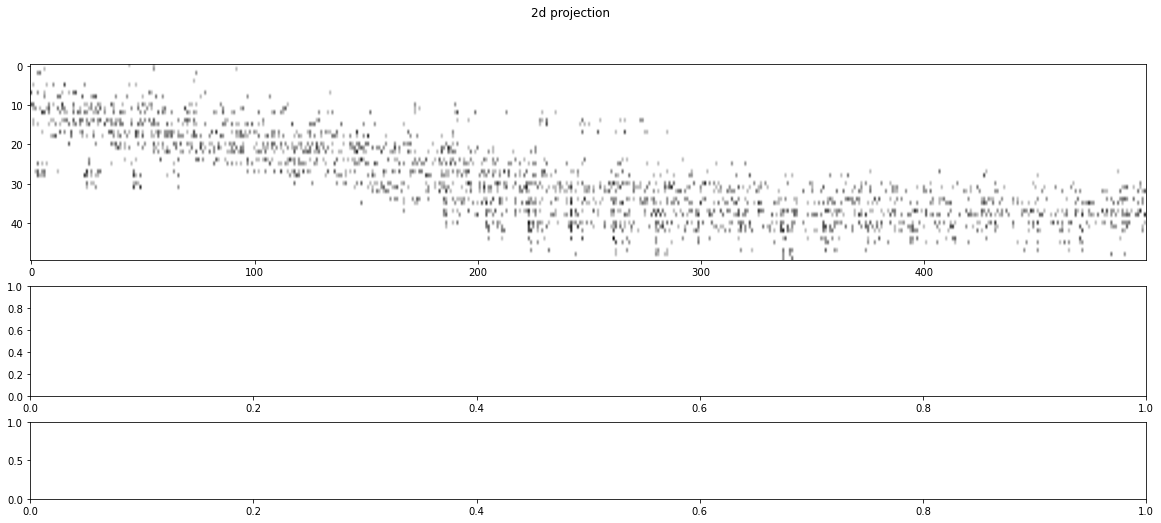

In [10]:
# width_x is the end of the last bucket on the x axis (usually t axis)
def get_projected_heatmap(df, col1, col2):
    df_proj = df.loc[:,[col1, col2]]

    heatmap, xedges, yedges = np.histogram2d(df_proj[col1], df_proj[col2], bins=[500, 50], density=False)
    heatmap = heatmap.T
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # heatmap = np.log2(heatmap+1)
    return df_proj, heatmap, extent

def hist2d_to_image(arr):
    max_val_ln = np.log(arr.max()+1)
    # log1p is ln(x+1)
    arr = np.log1p(arr) / max_val_ln # -> [0, 1]
    # make 0=white (=255), 1=black (=0)
    arr = ((arr * -1) + 1.0) * 255.0
    return arr.astype(int)

def show_fragment(sample_path):
    frag_path = DATASET_DIR / sample_path
    frag_df = pd.read_csv(frag_path, sep=",", header="infer")

    x_min = frag_df["x"].min()
    x_max = frag_df["x"].max()
    y_min = frag_df["y"].min()
    y_max = frag_df["y"].max()
    print(x_min, x_max)

    tx_df, tx_heatmap, tx_extent = get_projected_heatmap(frag_df, "t", "x")

    tx_heatmap_image = hist2d_to_image(tx_heatmap)

    fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [1280,720,500]})
    fig.set_size_inches(20, 8)
    fig.suptitle("2d projection")
    axs[0].imshow(tx_heatmap_image, origin='upper', cmap="gray", aspect="auto")
    fig.show()

T_SCALE = 0.002
T_BUCKET_LENGTH = 1000 * 100 # 100ms

DATASET_DIR = Path("../../datasets/insect/100ms_4096pts_fps-ds_sor-nr_norm_shufflet_2024-07-03_23-04-52")

show_fragment("bee/bee_m3_9_250.csv")
